 # Gillespie Algorithm - Work Implementation

## Import necessary modules

In [3]:
from math import log
import random
from matplotlib import pyplot
from numpy import linspace
from scipy.integrate import odeint

## Declare classes

In [4]:
class SSA:
    """Container for SSAs"""

    def __init__(self, model): #Initializes the class
        """Initialize container with model and pseudorandom number generator"""
        self.model = model #Assigns passed property to model
        self.random = random.random #Assigns random value as property

    def direct(self):
        """Indefinite generator of direct-method trajectories"""
        while True: #Initializes loop
            while not self.model.exit():

                # evaluate weights and partition
                weights = [ #creates list filled via iteration from passed reaction property
                    (rxn, sto, pro(self.model))
                    for (rxn, sto, pro) in self.model.reactions
                ]
                partition = sum(w[-1] for w in weights) #sums starting from the last element backwards

                # evaluate sojourn time (MC step 1)
                sojourn = log(1.0 / self.random()) / partition #calculates sojourn
                self.model["time"].append(self.model["time"][-1] + sojourn) #adds sojourn to time and appends

                # evaluate the reaction (MC step 2)
                partition = partition * self.random()
                while partition >= 0.0: #loop till partition is zero
                    rxn, sto, pro = weights.pop(0) #pops first element from weights and assigns 
                    partition -= pro #subtracts pro from partition
                for species, delta in sto.items(): #for every element in sto(ichiometry)
                    self.model[species].append(self.model[species][-1] + delta) #update stoichiometry from last element

                self.model.curate() #call curate method to check for valid reactions
            yield self.model #save the local variables in model for next time function is called 
            self.model.reset() #next call resumes from initial values resetted here

    def first_reaction(self):
        """Indefinite generator of 1st-reaction trajectories"""
        while True:
            while not self.model.exit(): #while exit is false

                # evaluate next reaction times
                times = [ #fills list via iteration for every reaction in model
                    (
                        log(
                            1.0 / self.random()
                        ) / pro(self.model),
                        sto
                    )
                    for (rxn, sto, pro) in self.model.reactions
                ]
                times.sort() #sorts times in ascending order

                # evaluate reaction time
                self.model["time"].append(
                    self.model["time"][-1] + times[0][0] #appends first elements in times to last time value in model
                )

                # evaluate reaction
                for species, delta in times[0][1].items():
                    self.model[species].append(
                        self.model[species][-1] + delta #updates stoichiometry after reaction
                    )

                self.model.curate() #call curate method to check for valid reactions
            yield self.model #save the local variables in model for next time function is called 
            self.model.reset() #next call resumes from initial values resetted here

class SSAModel(dict): #creates hash table dictionary to store modelled system's values
    """Container for SSA model"""

    def __init__(
        self, initial_conditions, propensities, stoichiometry
    ):
        """
        Initialize model with a dictionary of initial conditions (each
     
        """
        super().__init__(**initial_conditions) #passes to base class the variable number of elements in initial conditions
        self.reactions = list() #creates empty list
        self.excluded_reactions = list() #creates empty list
        for reaction,propensity in propensities.items(): #for every item in propensities
            if propensity(self) == 0.0: #if propensity is zero
                self.excluded_reactions.append( #append reaction to exluded_reactions list
                    (
                        reaction,
                        stoichiometry[reaction],
                        propensity
                    )
                )
            else: #otherwise appends it to list of valid reactions
                self.reactions.append(
                    (
                        reaction,
                        stoichiometry[reaction],
                        propensity
                    )
                )

    def exit(self): #property that exits if no valid reactions left in corresponding list
        """Return True to break out of trajectory"""

        # return True if no more reactions
        if len(self.reactions) == 0: return True

        # return False if there are more reactions
        else: return False

    def curate(self):
        """Validate and invalidate model reactions"""
        
        # evaulate possible reactions
        reactions = []
        while len(self.reactions) > 0: #while there are still valid reactions
            reaction = self.reactions.pop() #take last item in reactions into variable
            if reaction[2](self) == 0: #if there is no second reaction
                self.excluded_reactions.append(reaction) #excludes the first reaction popped above
            else: #otherwise it appends it
                reactions.append(reaction)
        reactions.sort() #sort the reactions
        self.reactions = reactions #passes reactions to the object

        # evaluate impossible reactions
        excluded_reactions = [] #creates empty list
        while len(self.excluded_reactions) > 0: #while there are reactions marked as exluded
            reaction = self.excluded_reactions.pop() #takes last item in excluded_reactions into variable
            if reaction[2](self) > 0: #checks if there are more reactions
                self.reactions.append(reaction) #if yes it appends them to valid reactions
            else:
                excluded_reactions.append(reaction) #otherwise it excludes them for good
        excluded_reactions.sort() #sorts excluded reactions
        self.excluded_reactions = excluded_reactions #passes excluded_reactions to the object

    def reset(self): #resets hashing values of dictionary to initial conditions
        """Clear the trajectory"""

        # reset species to initial conditions
        for key in self: del self[key][1:]

        # reset reactions per initial conditions
        self.curate()

## Program Body - Simulation Instantiation and Plotting

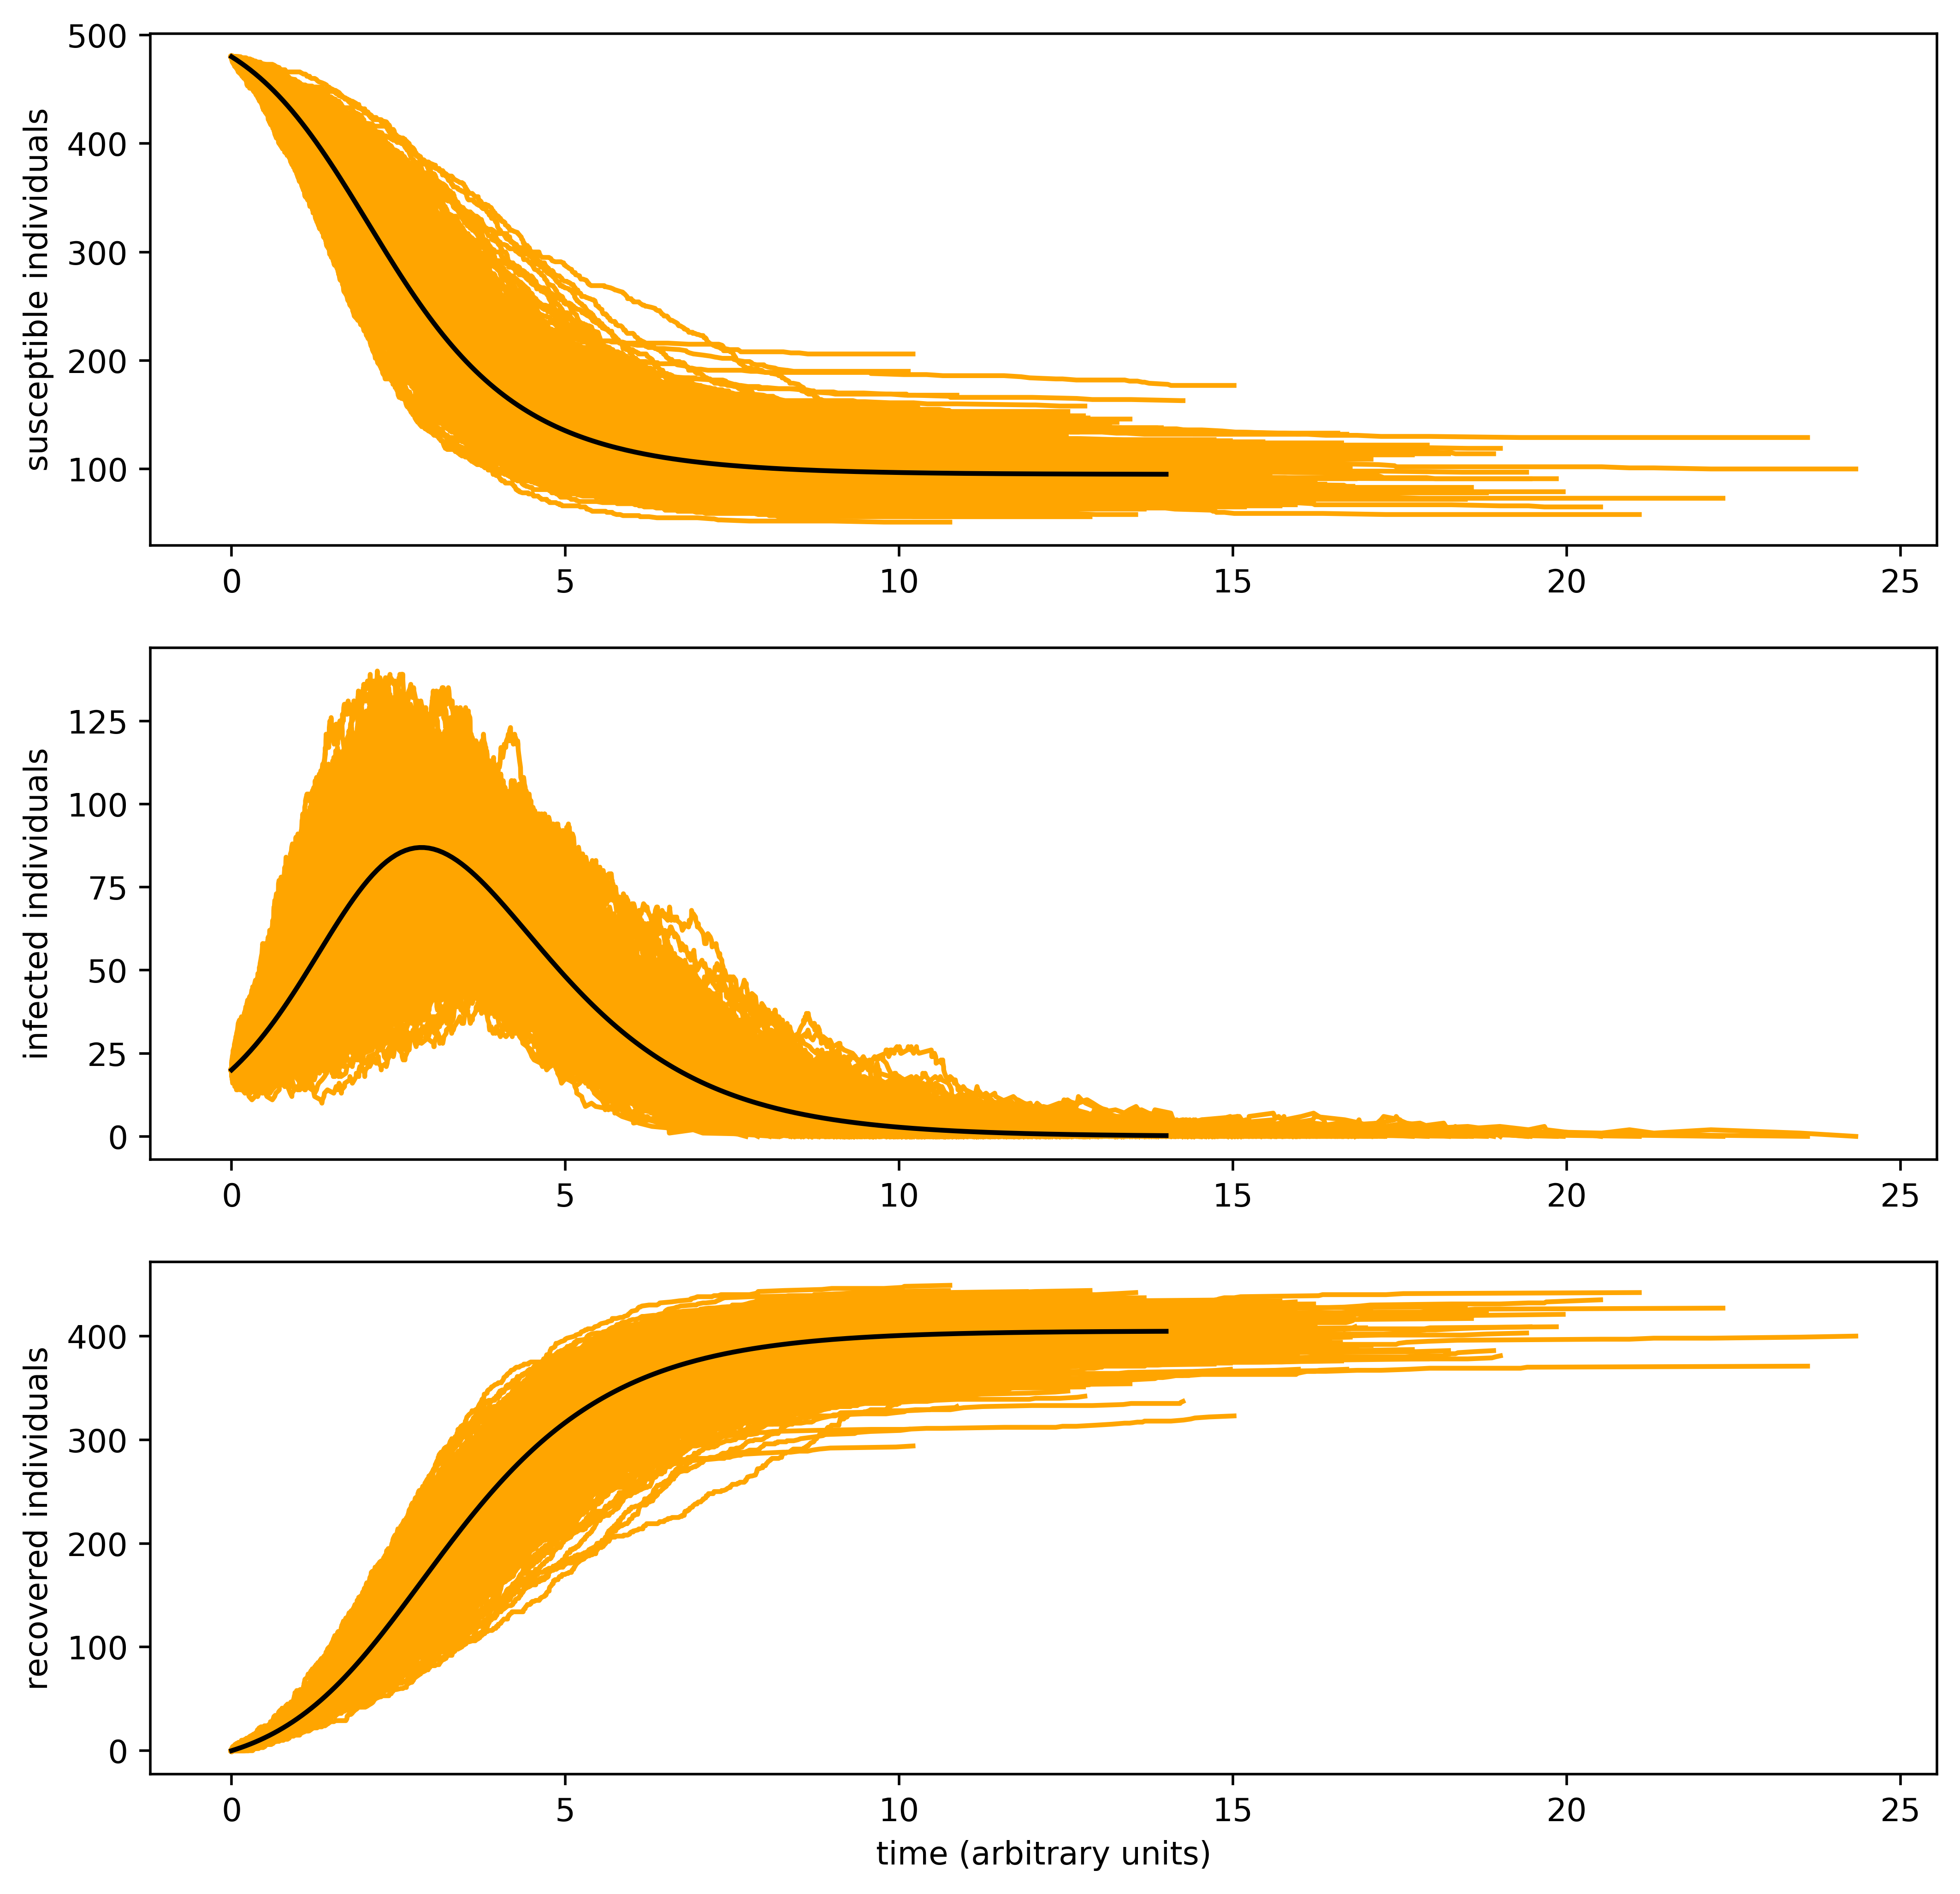

In [5]:
# Dictionaries containing data describing the model that will be simulated
initital_conditions = { #this dictionary contains all initial conditions - concentrations and initial time
    "s": [480], #concentrations...
    "i": [20],
    "r": [0],
    "time": [0.0], #initial time
}

propensities = {
    0: lambda d: 2.0 * d["s"][-1] * d["i"][-1] / 500,
    1: lambda d: 1.0 * d["i"][-1],
}

stoichiometry = { #self explanatory
    0: {"s": -1, "i": 1, "r": 0},
    1: {"s": 0, "i": -1, "r": 1},
}

# instantiate the epidemic SSA model container
epidemic = SSAModel( #this instantiation get things started and creates the container class for the model
    initital_conditions,
    propensities,
    stoichiometry
)

# instantiate the SSA container with model
epidemic_generator = SSA(epidemic)

# make a nice, big figure
pyplot.figure(figsize=(10,10), dpi=500)

# make a subplot for the susceptible, infected and recovered individuals
axes_s = pyplot.subplot(311)
axes_s.set_ylabel("susceptible individuals")

axes_i = pyplot.subplot(312)
axes_i.set_ylabel("infected individuals")

axes_r = pyplot.subplot(313)
axes_r.set_ylabel("recovered individuals")
axes_r.set_xlabel("time (arbitrary units)")

# simulate and plot n trajectories
trajectories = 0
for trajectory in epidemic_generator.direct(): #uses the direct method
    axes_s.plot(trajectory["time"], trajectory["s"], color="orange") #every trajectory is represented as orange line
    axes_i.plot(trajectory["time"], trajectory["i"], color="orange")
    axes_r.plot(trajectory["time"], trajectory["r"], color="orange")
    trajectories += 1
    if trajectories == 1000: #if intended trajectories reached, break the loop
        break

# numerical solution using an ordinary differential equation solversir
t = linspace(0, 14, num=200)
y0 = (480, 20, 0)
alpha = 2.0
beta = 1.0

#differential function to compute analytical solution

def differential_SIR(n_SIR, t, alpha, beta): #differentiation function! n_SIR handle to plug function result in itself
    dS_dt = -alpha * n_SIR[0] * n_SIR[1] / 500
    dI_dt = ((alpha * n_SIR[0] / 500) - beta) * n_SIR[1]
    dR_dt = beta * n_SIR[1]
    return dS_dt, dI_dt, dR_dt

solution = odeint(differential_SIR, y0, t, args=(alpha, beta))
solution = [[row[i] for row in solution] for i in range(3)]

# plot numerical solution
axes_s.plot(t, solution[0], color="black")
axes_i.plot(t, solution[1], color="black")
axes_r.plot(t, solution[2], color="black")

pyplot.show()